Converting annotations to object segmentation mask images

- https://towardsdatascience.com/generating-image-segmentation-masks-the-easy-way-dd4d3656dbd1
- https://copycoding.tistory.com/150

In [60]:
import os
import pandas as pd
import cv2
import json
import numpy as np 
import matplotlib.pyplot as plt
import ast

In [47]:
path_tetrapod = '/media/mvlab/46FA9CA2FA9C8FB3/dataset/pedestrian/Tongyoung/segment/'
os.path.isdir(path_tetrapod)

True

In [48]:
path_label = path_tetrapod + 'label/tetrapod_csv.csv'
path_json = path_tetrapod + 'label/tetrapod.json'

os.path.isfile(path_label), os.path.isfile(path_json)

(True, True)

In [51]:
df = pd.read_csv(path_label)
df.shape

(4, 7)

In [52]:
df

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,499.png,3157989,{},4,0,"{""name"":""polyline"",""all_points_x"":[1911,642,86...","{""class"":""water""}"
1,499.png,3157989,{},4,1,"{""name"":""polyline"",""all_points_x"":[470,260,84,...","{""class"":""water""}"
2,499.png,3157989,{},4,2,"{""name"":""polyline"",""all_points_x"":[645,855,113...","{""class"":""tetrapod""}"
3,499.png,3157989,{},4,3,"{""name"":""polyline"",""all_points_x"":[486,627,7,5...","{""class"":""land""}"


In [86]:
annotation = dict()

for i in range(len(df)):
    row = df.iloc[i]
    
    filename = row.filename
    region_shape_attributes = row.region_shape_attributes
    region_attributes = row.region_attributes
    points = ast.literal_eval(region_shape_attributes)
    cls = ast.literal_eval(region_attributes)
    #print(i, type(region_shape_attributes), type(points), points.keys())
    all_points_x = points['all_points_x']
    all_points_y = points['all_points_y']
    cls = cls['class']
    
    all_points_xy = np.stack((all_points_x, all_points_y), 1)
    
    print(i, filename, cls, all_points_xy.shape)
    if filename not in annotation.keys():        
        annotation[filename] = []
        
    annotation[filename].append([all_points_xy, cls])
    
len(annotation), annotation.keys()

0 499.png water (11, 2)
1 499.png water (10, 2)
2 499.png tetrapod (11, 2)
3 499.png land (6, 2)


(1, dict_keys(['499.png']))

In [109]:
len(annotation.keys())

1

In [118]:
mask = np.zeros((1000, 2000))

In [122]:
for key in annotation.keys():
    values = annotation[key]
    print(key, type(values), len(values))
    for value in values:
        points = value[0]
        cls = value[1]
        print(type(value), len(value), 'points', points.shape, cls)
        
        #points = np.array([sample_points]).reshape([-1, 2]).astype(np.int32)
        cv2.fillPoly(mask, [points], color=(np.random.randint(0, 255)))        
        

499.png <class 'list'> 4
<class 'list'> 2 points (11, 2) water
<class 'list'> 2 points (10, 2) water
<class 'list'> 2 points (11, 2) tetrapod
<class 'list'> 2 points (6, 2) land


In [105]:

points = np.array([sample_points]).reshape([-1, 2]).astype(np.int32)
cv2.fillPoly(mask, [points], color=(255))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

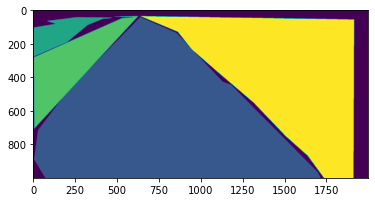

In [123]:
plt.imshow(mask)